In [213]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
pylab.rcParams['figure.figsize'] = (24, 18)

In [237]:
data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
price = clean_up_columns(data)
data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='mean')
v2 = clean_up_columns(data)
qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
markets=pd.read_csv('contracts.csv',index_col=0)
v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='m',how='sum')
fx=pd.read_csv('currency.csv',index_col=0,parse_dates=['DATE'])
fx['USD']=1
contract_size=pd.read_csv('mkts.csv',index_col='Market')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  app.launch_new_instance()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


In [215]:
df=pd.DataFrame()
df=price.copy()
for x in qd.columns:
    df[x]=qd[x]

# Correlation approach to clense data
Use pairwise correlation in order to decide which which markets are duplicates then use the one with the longer history. 

In [216]:
# Function to give list of correlations above a certain amount
def pair_correlation(df,level):
    corr=df.resample(rule='m',how='last').corr()
    pairs=[]
    for mkt in df.T.T.columns:
        ans= corr[mkt].sort_values().tail().head(4) >level
        if ans[ans].count() ==1:
            if mkt != ans[ans].index[0]:
                pairs.append([mkt,ans[ans].index[0]])
        elif ans[ans].count() ==0:
            continue
        else:
            print ans[ans]
    return pairs

In [217]:
# Function to seperate which has longer data.  takes a list of list
def longer_list(pairs):
    more =[]
    less =[]
    for x,y in pairs:
        if x == y:
            continue
        mkt1 =df[x].resample(rule='m',how='last').count()
        mkt2 =df[y].resample(rule='m',how='last').count()
        if mkt1>mkt2:
            more.append(x)
            less.append(y)
        else:
            more.append(y)
            less.append(x)        
    return more, less

In [218]:
pairs = pair_correlation(df,.995)
more , less = longer_list(pairs)

ICE-BRENT CRUDE OIL    True
ICE-GAS OIL            True
Name: NYM-NY HARBOR ULSD, dtype: bool
NYM-NY HARBOR ULSD    True
ICE-GAS OIL           True
Name: ICE-BRENT CRUDE OIL, dtype: bool

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()



ICE-BRENT CRUDE OIL    True
NYM-NY HARBOR ULSD     True
Name: ICE-GAS OIL, dtype: bool


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


In [219]:
cleansed = df.copy()
for rm_mkt in set(less):
    try:
        cleansed.drop(rm_mkt, axis=1, inplace=True)
    except:
        print rm_mkt
        
data = cleansed.resample(rule='m').last()[:'2016']
cleansed=cleansed.T[data.count()>48].T

In [220]:
df.count().count()

198

In [221]:
cleansed.count().count()

145

# Volume of contracts load


In [238]:
volume=pd.DataFrame()
volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='m',how='mean')[:'2016']
for x in v2.columns:
    name = x.split(' TRc1')[0]
    volume[name]=pd.rolling_mean(v2[x],250,min_periods=50).resample(rule='m',how='mean')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=50,window=250,center=False).mean()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


In [239]:
fx_map=contract_size.to_dict()['Currency']
tick_map=contract_size.to_dict()['Tick Value']
fx=fx.resample(rule='m',how='last')
px=cleansed.resample(rule='m',how='last')
total_vol=pd.DataFrame()
for m in cleansed.columns:
    curr= str(fx_map[m])
    try:
        total_vol[m] = (px[m]/fx[curr]*volume[m]*tick_map[m]).ffill()[:'2016'] 
    except:
        print m

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


MEXDER-10YR BOND
ZCE-RAPESEED MEAL
BMF-US DOLLAR
NORDPOOL-ENO QTR
EEX-MONTHLY PEAKLOAD
LIFFE-10Y E SWAPNOTE
LIFFE-2YR E SWAPNOTE
ENDEX-TTF GAS BASE LOAD
ENDEX-TTF GAS BASE LOAD QTR
ENDEX-TTF GAS BASE LOAD SEASON
Canadian Bankers Acceptance
Russian Ruble


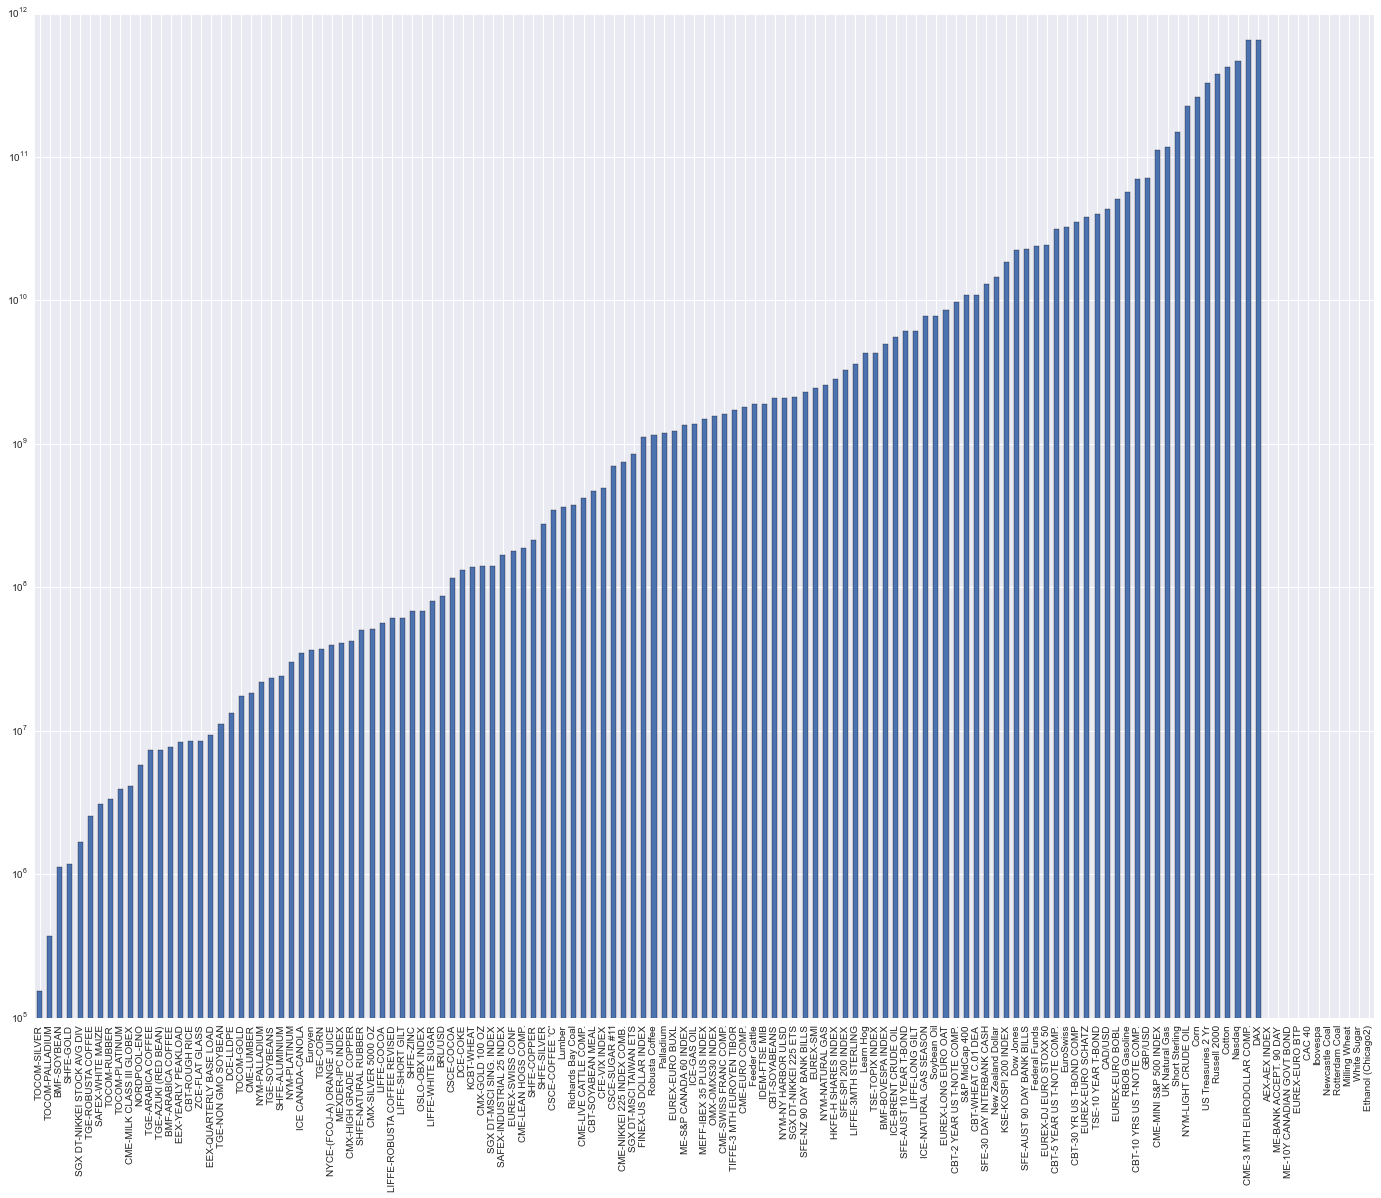

In [240]:
t=total_vol[:'2016'].tail(1).index[0]
total_vol[:'2016'].tail(1).T[t].sort_values().plot(kind='bar',logy=True)

In [241]:
total_vol[:'2016'].tail(1).T[t].sort_values().tail(10)

ME-BANK ACCEPT. 90 DAY      NaN
ME-10Y CANADIAN GOVT BOND   NaN
EUREX-EURO BTP              NaN
CAC 40                      NaN
Ibovespa                    NaN
Newcastle Coal              NaN
Rotterdam Coal              NaN
Milling Wheat               NaN
White Sugar                 NaN
Ethanol (Chicago2)          NaN
Name: 2016-12-31 00:00:00, dtype: float64

In [266]:
def quantile_columns(df,date,buckets,number):
    s=df.T[date].dropna()
    lower_range = number/float(buckets)
    upper_range = (number+1)/float(buckets)
    try:
        return list(s[(s>s.quantile(lower_range)) & (s<=s.quantile(upper_range))].dropna().index)
    except:
        print upper_range

In [286]:
bkts=[]
total_volume=total_vol
number_of_buckets=4
for y in range(2000,2016,1):
    year=str(y) + '-12-31'
    sharpes=[]
    sharpes.append(y)
    for i in range(0,number_of_buckets,1):
        mkts=quantile_columns(total_volume,year,number_of_buckets,i)
        sharpes.append(pnl.resample(rule='m',how='sum').T[year][mkts].mean())
    bkts.append(sharpes)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


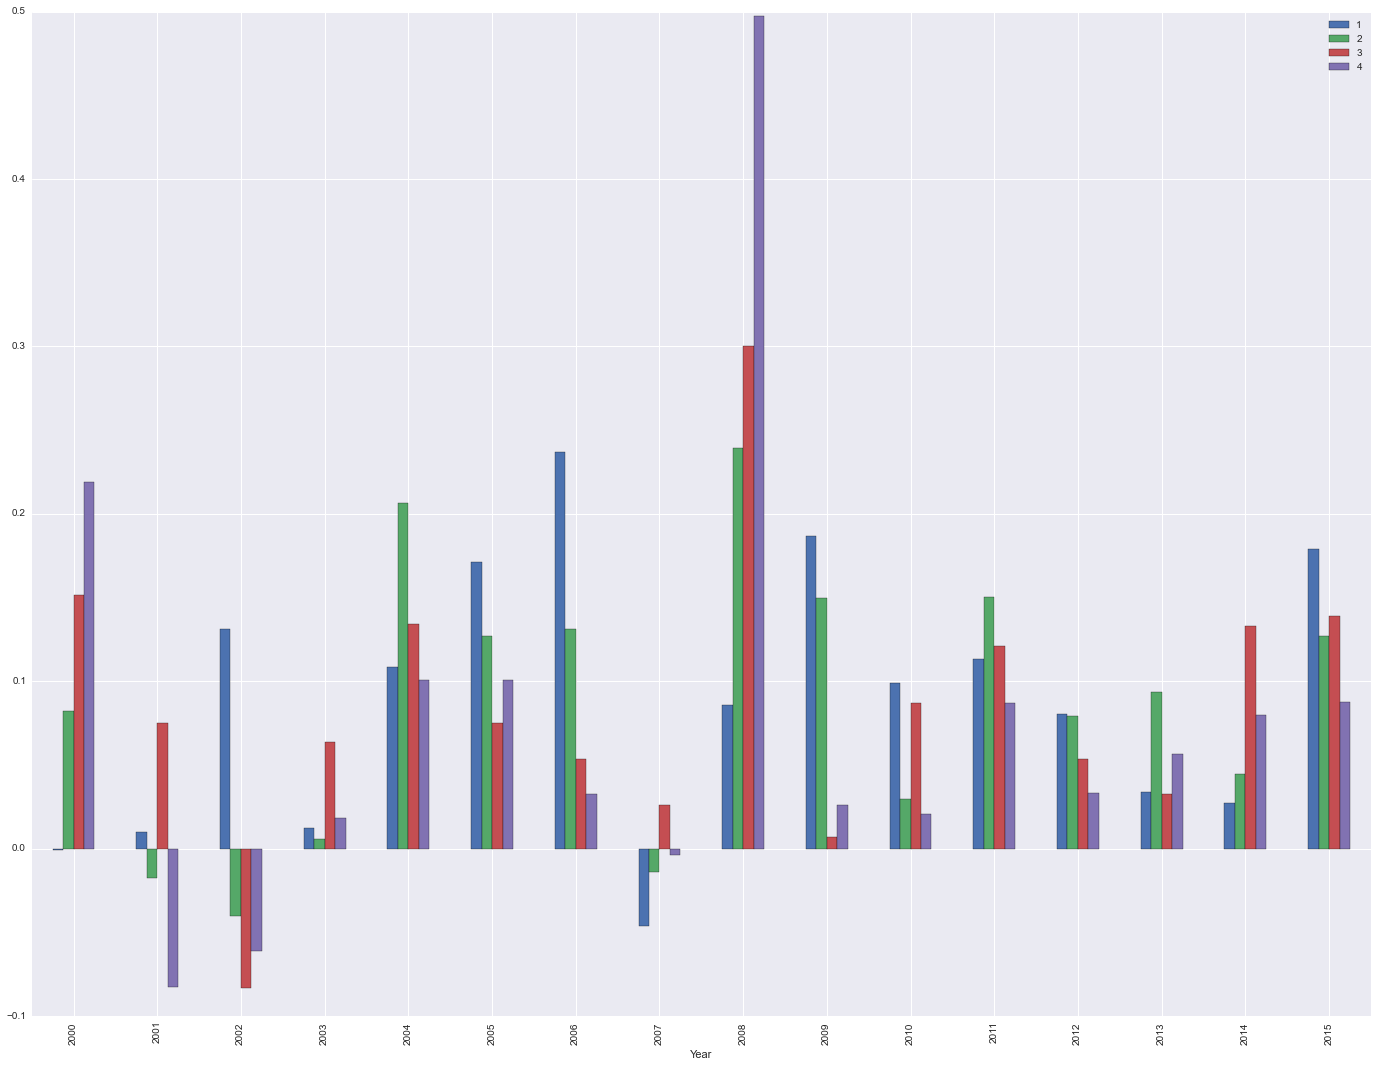

In [287]:
bkts
df=pd.DataFrame(bkts,columns=['Year','1','2','3','4']).set_index('Year')
df.plot(kind='bar')

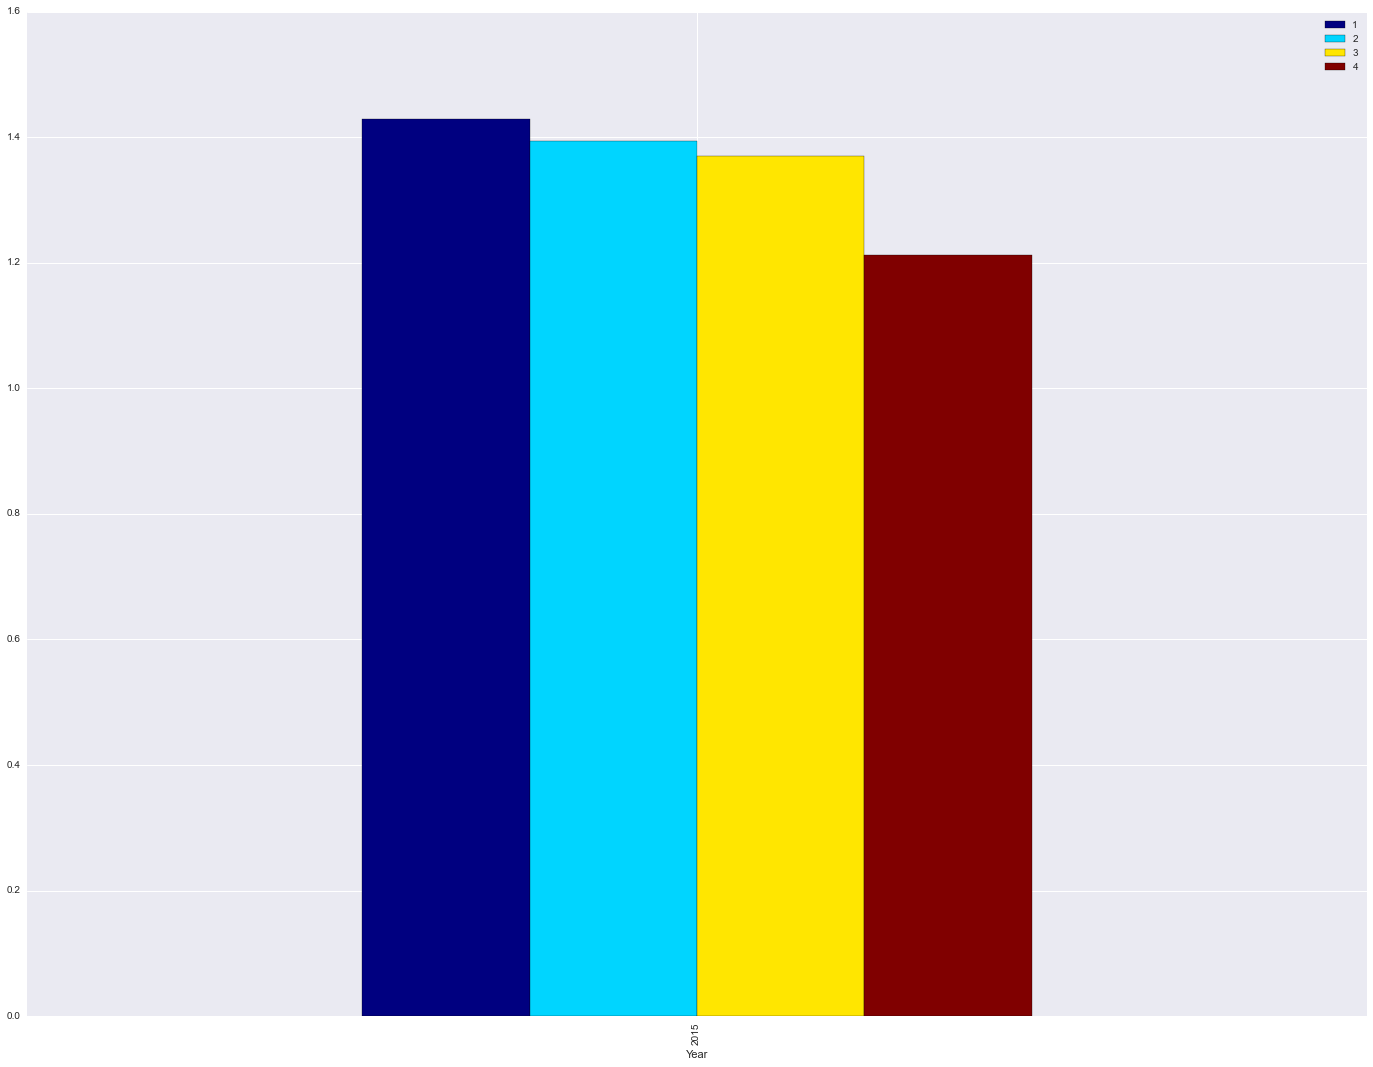

In [288]:
df.cumsum().tail(1).plot(kind='bar',colormap='jet')

In [289]:
df.corr()

,1,2,3,4
1,1.000000,0.492275,-0.098130,0.005172
2,0.492275,1.000000,0.631992,0.701739
3,-0.098130,0.631992,1.000000,0.853880
4,0.005172,0.701739,0.853880,1.000000


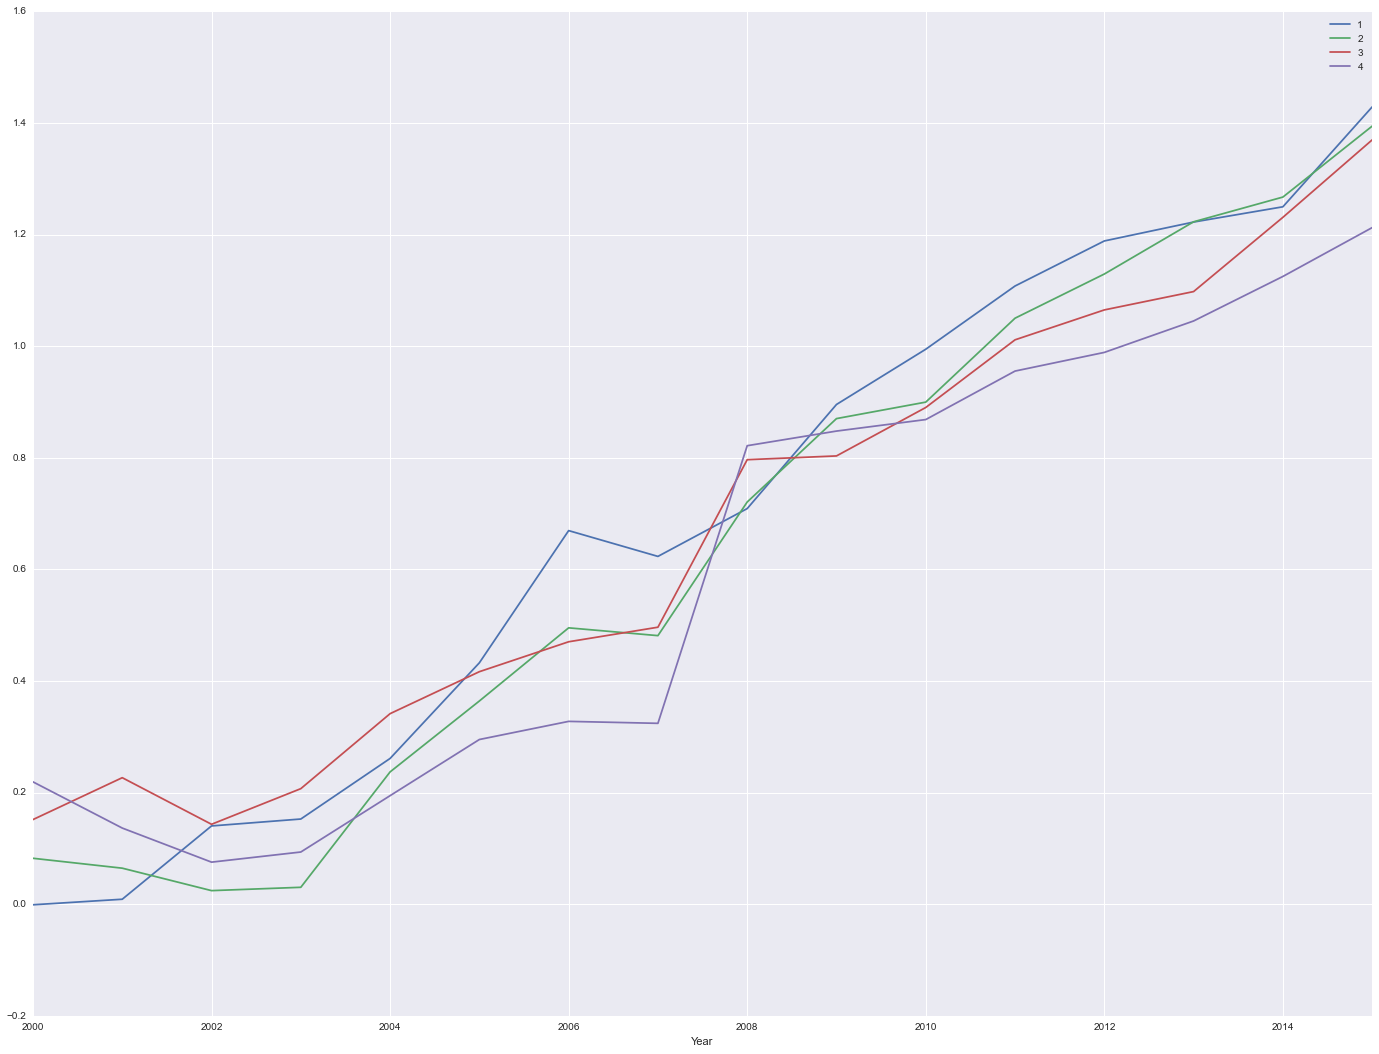

In [290]:
df.cumsum().plot()